In [16]:
import numpy as np
import gym
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plot

In [17]:
class Agent:
    def __init__(self, action_space, state_space):
        #hyperparameters, consider adding to constructor
        self.batch_size = 128
        self.learning_rate = 0.001
        self.RB_size = 100000
        self.gamma = 0.99
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decrement = 1e-4

        self.action_space = np.arange(action_space)

        #Deep Q Network
        self.dqn = DQN(self.learning_rate, action_space, state_space, 16)
        #Replay Buffer
        self.rb = ReplayBuffer(self.RB_size)

    def choose_action(self, state):
        if np.random.random() <= self.epsilon:
            return np.random.choice(self.action_space)
        else:
            if type(state) is tuple:    #I don't know why, but sometimes it is a tuple with index 0 the array and index 2 empty?~!
                state = state[0]
            state_ = torch.tensor([state]).to(self.dqn.device)
            actions = self.dqn.forward(state_)
            return torch.argmax(actions).item()

    def step(self):
        if len(self.rb) < self.batch_size:
            return


        self.dqn.optim.zero_grad()

        batch = self.rb.get_nbest(self.batch_size)
        for trajectory in batch:
            trajectory_state = trajectory["state"]
            if type(trajectory_state) is tuple:    #I don't know why, but sometimes it is a tuple with index 0 the array and index 2 empty?~!
                trajectory_state = trajectory_state[0]
            q_eval = self.dqn.forward(torch.tensor(trajectory_state).to(self.dqn.device))

            trajectory_action = trajectory["action"]

            trajectory_next_state = trajectory["new_state"]
            q_next = self.dqn.forward(torch.tensor(trajectory_next_state).to(self.dqn.device))

            trajectory_reward = trajectory["reward"]

            q_target = trajectory_reward + self.gamma * torch.max(q_next)

            loss = self.dqn.loss(q_target, q_eval[trajectory_action]).to(self.dqn.device)
            loss.backward()

        self.dqn.optim.step()

        self.epsilon = self.epsilon - self.epsilon_decrement if self.epsilon > self.epsilon_min else self.epsilon_min



In [18]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []

    def add_sample(self, current_state, new_state, action, rewards):
        trajectory = {"state": current_state, "new_state": new_state, "action":action, "reward": rewards}
        self.buffer.append(trajectory)

    def sort(self):
        #sort buffer
        self.buffer = sorted(self.buffer, key = lambda i: i["reward"],reverse=True)
        # keep the max buffer size
        self.buffer = self.buffer[:self.max_size]

    def get_random_samples(self, batch_size):
        self.sort()
        idxs = np.random.randint(0, len(self.buffer), batch_size)
        batch = [self.buffer[idx] for idx in idxs]
        return batch

    def get_nbest(self, n):
        self.sort()
        return self.buffer[:n]

    def __len__(self):
        return len(self.buffer)

In [19]:
class DQN(nn.Module):
    def __init__(self, learning_rate, action_space, state_space, hidden_size):
        super(DQN, self).__init__()
        self.actions = np.arange(action_space)
        self.fc1 = nn.Linear(state_space, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_space)
        self.loss = nn.MSELoss()

        self.optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

100%|██████████| 30/30 [00:36<00:00,  1.22s/it]

21.4


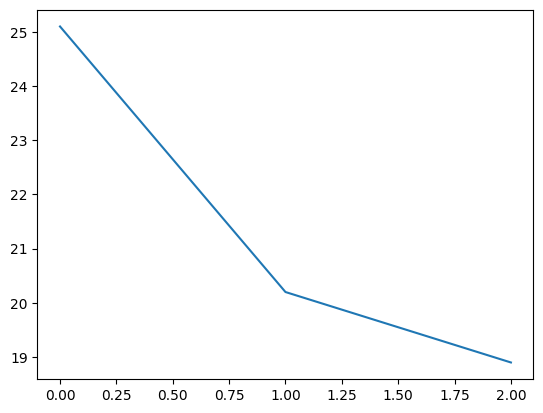

In [20]:
env = gym.make("CartPole-v1")
action_space = env.action_space.n
state_space = env.observation_space.shape[0]

iterations = 1200

final_rewards = []
agent = Agent(action_space, state_space)
for i in tqdm(range(iterations)):
    states, new_states, actions, rewards = [], [], [], []
    truncated = False
    terminated = False
    observation = env.reset()
    while not (truncated or terminated):
        action = agent.choose_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        agent.rb.add_sample(observation, next_observation, action, reward)
        states.append(observation)
        new_states.append(next_observation)
        actions.append(action)
        rewards.append(reward)
        agent.step()
        observation = next_observation
    final_rewards.append(sum(rewards))

print(np.mean(final_rewards))
# print(final_rewards)
avg_per_10 = np.zeros(int(iterations/10))
for i in range(iterations):
    avg_per_10[i//10] += final_rewards[i]
avg_per_10 = avg_per_10 / 10

plot.plot(avg_per_10)